In [78]:
# Importing Libaries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error as mse , mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [79]:
# getting unique files 
Stock_files = os.listdir("./Data")
Twitter_files = os.listdir("./twitter")

print(f"The Number Of Unique Stocks and Twitter_sentiments files are {len(Stock_files)} and {len(Twitter_files)} ")

The Number Of Unique Stocks and Twitter_sentiments files are 30 and 30 


In [80]:
# gathering Data

stock_df = pd.DataFrame()

for i in Stock_files:
  stk = i[10:]
  stk_name = i.split(".")[0][15:]
  tw = [j for j in Twitter_files if stk in j]
  df1 = pd.read_csv("./Data/"+i)
  df2 = pd.read_csv("./twitter/"+tw[0])
  
  df1 = df1.rename(columns={"Unnamed: 0": "Date"})
  df2 = df2.rename(columns={"Unnamed: 0": "Date"})
  df3 = pd.merge(df1,df2,on="Date",how="left")
  df3["stock_name"] = stk_name 
  
  stock_df = pd.concat([stock_df,df3],axis=0,ignore_index=True)
  # print(stock_df.shape)

print("The shape of Data is ",stock_df.shape)
stock_df.head()

The shape of Data is  (10200, 10)


,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name
0,2013-05-31,77.39,75.75,76.07,75.73,NaN,NaN,NaN,NaN,AXP
1,2013-06-03,76.67,76.48,75.89,75.63,0.0,10.0,1.0,11.0,AXP
2,2013-06-04,77.24,76.02,76.50,75.96,2.0,12.0,6.0,20.0,AXP
3,2013-06-05,76.28,74.79,76.04,74.64,0.0,4.0,2.0,6.0,AXP
4,2013-06-06,76.25,76.24,74.75,74.64,1.0,9.0,0.0,10.0,AXP


In [81]:
stock_df.corr()

,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW
HIGH,1.000000,0.999925,0.999933,0.999910,0.003889,-0.058826,-0.031833,-0.051087
CLOSE,0.999925,1.000000,0.999839,0.999937,0.002449,-0.059723,-0.032782,-0.052271
OPEN,0.999933,0.999839,1.000000,0.999911,0.003510,-0.059500,-0.033300,-0.052049
LOW,0.999910,0.999937,0.999911,1.000000,0.001797,-0.060452,-0.034147,-0.053296
NUM_NEG,0.003889,0.002449,0.003510,0.001797,1.000000,0.446605,0.294067,0.593973
NUM_NEU,-0.058826,-0.059723,-0.059500,-0.060452,0.446605,1.000000,0.497090,0.954320
NUM_POS,-0.031833,-0.032782,-0.033300,-0.034147,0.294067,0.497090,1.000000,0.690463
TW,-0.051087,-0.052271,-0.052049,-0.053296,0.593973,0.954320,0.690463,1.000000


In [82]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        10200 non-null  object 
 1   HIGH        9870 non-null   float64
 2   CLOSE       9870 non-null   float64
 3   OPEN        9870 non-null   float64
 4   LOW         9870 non-null   float64
 5   NUM_NEG     10194 non-null  float64
 6   NUM_NEU     10194 non-null  float64
 7   NUM_POS     10194 non-null  float64
 8   TW          10194 non-null  float64
 9   stock_name  10200 non-null  object 
dtypes: float64(8), object(2)
memory usage: 797.0+ KB


#  <font color='green'>EDA</font> 

In [83]:
# Generating Day ,Month ,Year columns
stock_df["day"]=pd.to_datetime(stock_df["Date"]).dt.day
stock_df["month"]=pd.to_datetime(stock_df["Date"]).dt.month
stock_df["year"]=pd.to_datetime(stock_df["Date"]).dt.year
stock_df["Date"]=pd.to_datetime(stock_df["Date"])

In [106]:
# sorting the data w.r.t Date
stock_df.sort_values(by="Date",inplace=True,ignore_index=True)
stock_df

,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name,day,month,year
0,2013-05-31,24.53,24.09,24.20,24.09,0.0,1.0,0.0,1.0,CSCO,31,5,2013
1,2013-05-31,85.99,84.24,85.63,84.20,0.0,2.0,0.0,2.0,JNJ,31,5,2013
2,2013-05-31,86.95,85.80,86.23,85.80,0.0,1.0,0.0,1.0,CAT,31,5,2013
3,2013-05-31,57.25,55.79,56.06,55.79,0.0,1.0,0.0,1.0,DD,31,5,2013
4,2013-05-31,112.21,110.31,110.79,110.30,0.0,1.0,0.0,1.0,MMM,31,5,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2014-09-18,108.66,108.52,107.41,107.41,0.0,1.0,2.0,3.0,UTX,18,9,2014
10196,2014-09-18,76.58,76.22,76.09,75.91,0.0,10.0,0.0,10.0,WMT,18,9,2014
10197,2014-09-18,90.59,90.09,89.27,89.27,1.0,1.0,0.0,2.0,AXP,18,9,2014
10198,2014-09-18,46.83,46.68,46.60,46.46,3.0,20.0,14.0,37.0,MSFT,18,9,2014


In [85]:
df=stock_df.drop(columns=["HIGH","OPEN","LOW"],axis=1)
df

,Date,CLOSE,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name,day,month,year
0,2013-05-31,75.75,NaN,NaN,NaN,NaN,AXP,31,5,2013
1,2013-05-31,24.09,0.0,1.0,0.0,1.0,CSCO,31,5,2013
2,2013-05-31,61.68,0.0,1.0,0.0,1.0,NKE,31,5,2013
3,2013-05-31,178.17,0.0,1.0,0.0,1.0,V,31,5,2013
4,2013-05-31,90.49,0.0,2.0,0.0,2.0,XOM,31,5,2013
...,...,...,...,...,...,...,...,...,...,...
10195,2014-09-18,87.63,0.0,1.0,0.0,1.0,UNH,18,9,2014
10196,2014-09-18,108.52,0.0,1.0,2.0,3.0,UTX,18,9,2014
10197,2014-09-18,216.10,0.0,2.0,0.0,2.0,V,18,9,2014
10198,2014-09-18,61.31,0.0,5.0,0.0,5.0,JPM,18,9,2014


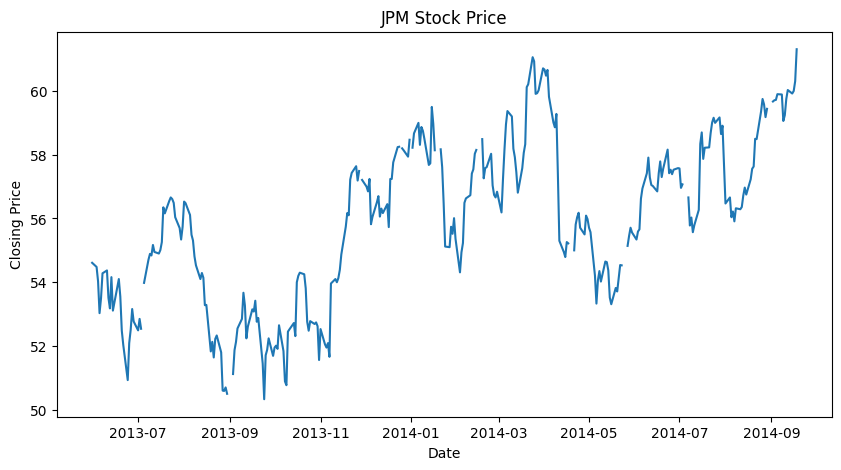

In [86]:
data = df[df["stock_name"] == "JPM"]
plt.figure(figsize=(10,5))
plt.plot(data["Date"], data["CLOSE"])
plt.title("JPM Stock Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

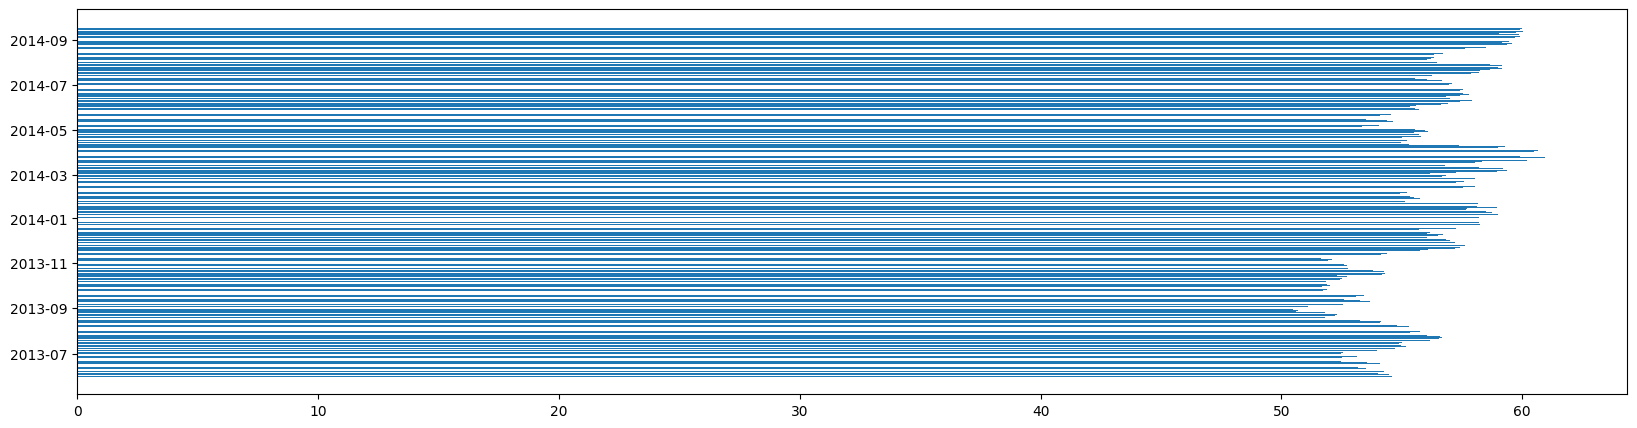

In [87]:
plt.figure(figsize=(20,5))
data=df[df["stock_name"]=="JPM"]
plt.barh(data["Date"],data["CLOSE"])
plt.show()

In [104]:
df.isna().sum()

Date          0
CLOSE         0
NUM_NEG       0
NUM_NEU       0
NUM_POS       0
TW            0
stock_name    0
day           0
month         0
year          0
dtype: int64

In [99]:
# droping the Null val
df.dropna(inplace=True)


In [100]:
# x_train = df.iloc[:int(9864*80/100)]
# y_train=x_train["CLOSE"]
# x_train.drop(columns=["CLOSE","Date"],inplace=True,axis=1)


# x_test = df.iloc[int(9864*80/100):]
# y_test = x_test["CLOSE"] 
# x_test.drop(["CLOSE","Date"],inplace=True,axis=1)

In [101]:
from sklearn.model_selection import train_test_split

x = df.drop(["CLOSE", "Date"], axis=1)
y = df["CLOSE"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [102]:
x_train.shape,x_test.shape

((7891, 8), (1973, 8))

In [103]:
# converting Stock_name column to Numerical
le=LabelEncoder()
le.fit(x_train["stock_name"])
x_train["stock_name"]=le.transform(x_train["stock_name"])
x_test["stock_name"]=le.transform(x_test["stock_name"])

integer_mapping = {l: i for i, l in enumerate(le.classes_)}

integer_mapping['NKE']


19

In [64]:
x_train[x_train['day']==18,x_train['stock_name']==40]

,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name,day,month,year
10190,0.0,7.0,2.0,9.0,19,18,9,2014
8209,0.0,18.0,2.0,20.0,24,18,6,2014
2353,1.0,102.0,13.0,116.0,7,18,9,2013
8213,10.0,224.0,48.0,282.0,18,18,6,2014
3023,7.0,29.0,4.0,40.0,9,18,10,2013
...,...,...,...,...,...,...,...,...
3647,0.0,33.0,8.0,41.0,0,18,11,2013
6235,9.0,165.0,35.0,209.0,6,18,3,2014
8877,5.0,13.0,4.0,22.0,23,18,7,2014
8192,4.0,141.0,43.0,188.0,14,18,6,2014


In [58]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

lr.fit(x_train,y_train)

pred = lr.predict(x_test)

score=r2_score(y_test,pred)
m_score=mse(y_test,pred)
mae_score=mae(y_test,pred)
print(pred[10])

print(f"The R2_score is ={score} \n The RMSE is {math.sqrt(m_score)} \n The mae is = {mae_score}")

79.92827321215009
The R2_score is =0.007191919018955439 
 The RMSE is 43.01568214507945 
 The mae is = 32.088039115326936


In [59]:
# random forest Regressor

params={'max_depth':[5,10,30,50],
        'min_samples_split':[2,3,5,10],
        }

rf = RandomForestRegressor()

cross_val = RandomizedSearchCV(rf,param_distributions=params ,cv=5 ,n_iter=10,n_jobs=-1,verbose=2)
cross_val.fit(x_train,y_train) 
# cross_val.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 30, 50],
                                        'min_samples_split': [2, 3, 5, 10]},
                   verbose=2)

In [60]:
cross_val.best_params_

{'min_samples_split': 2, 'max_depth': 30}

In [61]:
rf_best = cross_val.best_estimator_
rf_best.fit(x_train,y_train)

pred = rf_best.predict(x_test)
score=r2_score(y_test,pred)
m_score=mse(y_test,pred)

print(f"The R2_score is = {score} \n The RMSE is {math.sqrt(m_score)} ")

The R2_score is = 0.9982307882715837 
 The RMSE is 1.8158671307904783 


In [62]:
x_test

,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name,day,month,year
10082,6.0,244.0,10.0,260.0,14,15,9,2014
506,4.0,13.0,1.0,18.0,21,24,6,2013
5038,1.0,39.0,19.0,59.0,0,21,1,2014
908,0.0,11.0,1.0,12.0,19,12,7,2013
6418,9.0,155.0,16.0,180.0,7,26,3,2014
...,...,...,...,...,...,...,...,...
7480,14.0,219.0,12.0,245.0,7,15,5,2014
3499,0.0,38.0,5.0,43.0,21,11,11,2013
1924,1.0,4.0,3.0,8.0,5,29,8,2013
4753,1.0,43.0,5.0,49.0,9,8,1,2014


In [46]:
mae_score=mae(y_test,pred)
print(mae_score)

3.7925133883015985


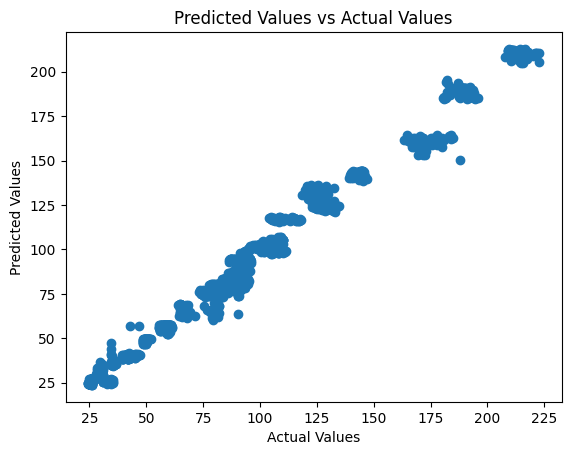

In [47]:
import matplotlib.pyplot as plt

# Assuming you have already trained and made predictions on your data

actual_values = y_test

# Plot a scatter plot of predicted values against actual values
plt.scatter(actual_values, pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs Actual Values')
plt.show()


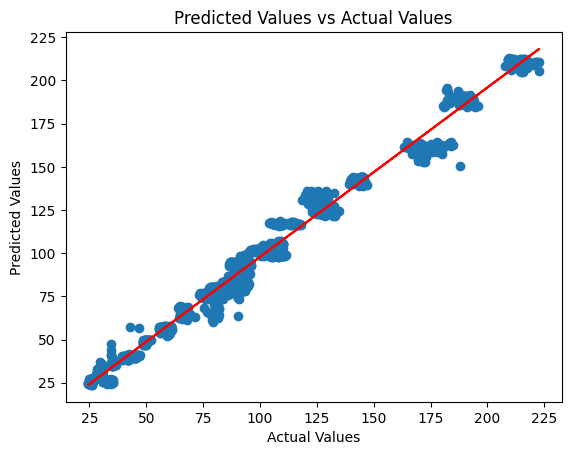

In [48]:
# Calculate the coefficients of the best fit line
coefficients = np.polyfit(actual_values, pred, 1)
p = np.poly1d(coefficients)

# Create a line plot of predicted values against actual values
plt.plot(actual_values, pred, 'o')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs Actual Values')

# Plot the best fit line
plt.plot(actual_values, p(actual_values), 'r-')

plt.show()

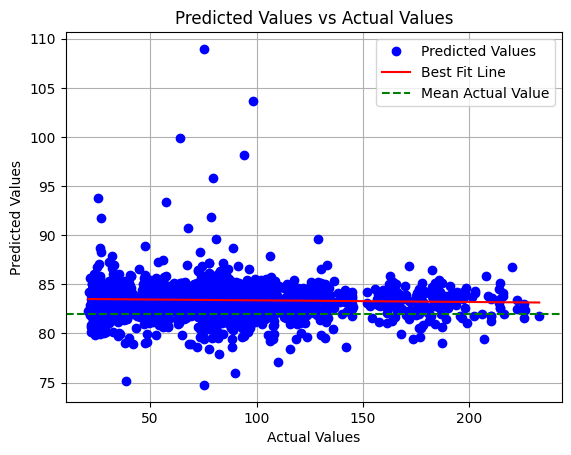

In [29]:
# Calculate the coefficients of the best fit line
coefficients = np.polyfit(actual_values, pred, 1)
p = np.poly1d(coefficients)

# Create a line plot of predicted values against actual values
plt.plot(actual_values, pred, 'o', color='blue', label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs Actual Values')
plt.grid(True)

# Plot the best fit line and confidence interval
x = np.linspace(min(actual_values), max(actual_values), 100)
y_fit = p(x)
y_err = pred - p(actual_values)
mean_squared_error = np.mean(y_err**2)
std_deviation = np.sqrt(mean_squared_error)
confidence_interval = 1.96 * std_deviation
plt.plot(x, y_fit, color='red', label='Best Fit Line')

# Add a horizontal line at the mean value of the actual values
mean_actual = np.mean(actual_values)
plt.axhline(y=mean_actual, color='green', linestyle='--', label='Mean Actual Value')

plt.legend()
plt.show()
